In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/AI4E_ML01'

/content/drive/MyDrive/AI4E_ML01


In [ ]:
!ls

 data_description.txt
'gilat paper.csv'
'gilat paper.xlsx'
 HW_W7_Randomforest_Thao.ipynb
'HW_W9_Gradient BoostingRegressor_Thao.ipynb'
 linear.csv
 map.jpeg
 nonLinear.csv
 sample.csv
 sample_submission.csv
 test.csv
 train.csv
 WA_Fn-UseC_-Telco-Customer-Churn.csv
 weather_forecast.csv


In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import seaborn as sns

#Implement Gradient Boosting 

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss

class GradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        self.estimator_weights = []

    def fit(self, X, y):
        sample_weights = np.ones(len(X)) / len(X)
        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, y, sample_weight=sample_weights)
            predictions = tree.predict(X)
            log_loss_value = log_loss(y, predictions)

            estimator_weight = self.learning_rate * np.log((1 - log_loss_value) / log_loss_value)

            sample_weights *= np.exp(estimator_weight * y * predictions) / np.sum(sample_weights)

            self.estimators.append(tree)
            self.estimator_weights.append(estimator_weight)

    def predict_proba(self, X):
        weighted_predictions = sum(estimator.predict(X) * weight for estimator, weight in zip(self.estimators, self.estimator_weights))
        probabilities = 1 / (1 + np.exp(-weighted_predictions))
        return np.column_stack((1 - probabilities, probabilities))

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [ ]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', engine='c')
df.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   
5               Yes     Fiber optic             No  ...              Yes   
6               Yes     Fiber optic             No  ...               No   
7  No phone service             DSL            Yes  ...               No   
8               Yes     Fiber optic             No  ...              Yes   
9                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   
5          No         Yes             Yes  Month-to-month              Yes   
6          No         Yes              No  Month-to-month              Yes   
7          No          No              No  Month-to-month               No   
8         Yes         Yes             Yes  Month-to-month              Yes   
9          No          No              No        One year               No   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  
5           Electronic check          99.65         820.5   Yes  
6    Credit card (automatic)          89.10        1949.4    No  
7               Mailed check          29.75         301.9    No  
8           Electronic check         104.80       3046.05   Yes  
9  Bank transfer (automatic)          56.15       3487.95    No  

[10 rows x 21 columns]

# **EDA**

In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [ ]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Encoding, changing catergorical to numeric data

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df1 = df.copy(deep = True)
text_data_features = [i for i in df.columns if i not in df.describe().columns]

print('Label Encoder Transformation')
for i in text_data_features :
    df1[i] = le.fit_transform(df1[i])
    print(i,' : ',df1[i].unique(),' = ',le.inverse_transform(df1[i].unique()))

Label Encoder Transformation
customerID  :  [5375 3962 2564 ... 3367 5934 2226]  =  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mail

# **Modelling**

In [ ]:
df1.head(10)

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0        5375       0              0        1           0       1   
1        3962       1              0        0           0      34   
2        2564       1              0        0           0       2   
3        5535       1              0        0           0      45   
4        6511       0              0        0           0       2   
5        6551       0              0        0           0       8   
6        1002       1              0        0           1      22   
7        4770       0              0        0           0      10   
8        5604       0              0        1           0      28   
9        4534       1              0        0           1      62   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0             0              1                0               0  ...   
1             1              0                0               2  ...   
2             1              0                0               2  ...   
3             0              1                0               2  ...   
4             1              0                1               0  ...   
5             1              2                1               0  ...   
6             1              2                1               0  ...   
7             0              1                0               2  ...   
8             1              2                1               0  ...   
9             1              0                0               2  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   
3                 2            2            0                0         1   
4                 0            0            0                0         0   
5                 2            0            2                2         0   
6                 0            0            2                0         0   
7                 0            0            0                0         0   
8                 2            2            2                2         0   
9                 0            0            0                0         1   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 1              2           29.85          2505      0  
1                 0              3           56.95          1466      0  
2                 1              3           53.85           157      1  
3                 0              0           42.30          1400      0  
4                 1              2           70.70           925      1  
5                 1              2           99.65          6104      1  
6                 1              1           89.10          1550      0  
7                 0              3           29.75          2609      0  
8                 1              2          104.80          2646      1  
9                 0              0           56.15          3022      0  

[10 rows x 21 columns]

In [ ]:
df=df1.drop(columns =['customerID'],axis = 1)

In [ ]:
X = df.drop(columns = ['Churn'])
y = df['Churn']

In [ ]:
validation_size = 0.2
seed = 7
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)
num_folds = 10

In [ ]:
n_estimators = 100  
learning_rate = 0.1  
max_depth = 3  
model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)


In [ ]:
model.fit(X_train, y_train)


In [ ]:
y_pred = model.predict(X_validation)

In [ ]:
accuracy = accuracy_score(y_validation, y_pred)
print(classification_report(y_validation, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1021
           1       0.28      1.00      0.43       388

    accuracy                           0.28      1409
   macro avg       0.14      0.50      0.22      1409
weighted avg       0.08      0.28      0.12      1409



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Tuning only learning rate**

In [ ]:
param_grid = { 'n_estimators': [100],
    'learning_rate': [1,0.9, 0.8, 0.7, 0.5, 0.4, 0.3, 0.25, 0.1, 0.05, 0.01],
    'max_depth': [3]}

In [ ]:
model = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',verbose=10)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5; 1/11] START learning_rate=1, max_depth=3, n_estimators=100.............
[CV 1/5; 1/11] END learning_rate=1, max_depth=3, n_estimators=100;, score=0.263 total time=   4.3s
[CV 2/5; 1/11] START learning_rate=1, max_depth=3, n_estimators=100.............
[CV 2/5; 1/11] END learning_rate=1, max_depth=3, n_estimators=100;, score=0.263 total time=   3.6s
[CV 3/5; 1/11] START learning_rate=1, max_depth=3, n_estimators=100.............
[CV 3/5; 1/11] END learning_rate=1, max_depth=3, n_estimators=100;, score=0.263 total time=   2.7s
[CV 4/5; 1/11] START learning_rate=1, max_depth=3, n_estimators=100.............
[CV 4/5; 1/11] END learning_rate=1, max_depth=3, n_estimators=100;, score=0.264 total time=   3.2s
[CV 5/5; 1/11] START learning_rate=1, max_depth=3, n_estimators=100.............
[CV 5/5; 1/11] END learning_rate=1, max_depth=3, n_estimators=100;, score=0.263 total time=   3.7s
[CV 1/5; 2/11] START learning_rate=0.9,

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [1, 0.9, 0.8, 0.7, 0.5, 0.4, 0.3,
                                           0.25, 0.1, 0.05, 0.01],
                         'max_depth': [3], 'n_estimators': [100]},
             scoring='accuracy', verbose=10)

In [ ]:
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 100}
Best accuracy:  0.2628683012319918


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_validation)
accuracy = accuracy_score(y_validation, y_pred)
print("Validation accuracy:", accuracy)

Validation accuracy: 0.2753726046841732


**Visualize the loss with different learning rates**


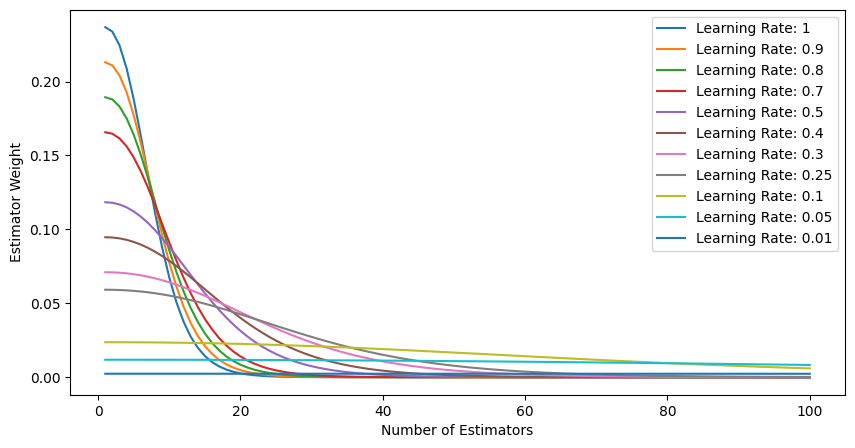

In [ ]:
learning_rates = [1, 0.9, 0.8, 0.7, 0.5, 0.4, 0.3, 0.25, 0.1, 0.05, 0.01] # Different learning rates to try
train_loss = []
num_estimators = 100

for learning_rate in learning_rates:
    model = GradientBoostingClassifier(n_estimators=num_estimators, learning_rate=learning_rate)
    model.fit(X_train, y_train)

    learning_rate_train_loss = []
    for i in range(num_estimators):
        learning_rate_train_loss.append(model.estimator_weights[i])

    train_loss.append(learning_rate_train_loss)

plt.figure(figsize=(10, 5))
for i, learning_rate in enumerate(learning_rates):
    plt.plot(np.arange(num_estimators) + 1, train_loss[i], label='Learning Rate: {}'.format(learning_rate))

plt.xlabel('Number of Estimators')
plt.ylabel('Estimator Weight')
plt.legend()
plt.show()



# **Tuning all parameters**

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5]}


In [ ]:
model = GradientBoostingClassifier()


In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',verbose=10)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........
[CV 1/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.263 total time=   1.5s
[CV 2/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........
[CV 2/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.263 total time=   1.5s
[CV 3/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........
[CV 3/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.263 total time=   3.6s
[CV 4/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........
[CV 4/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.264 total time=   5.0s
[CV 5/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........
[CV 5/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.263 total time=   2.8s
[CV 1/5; 2/27] START learnin

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=10)

In [ ]:
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best accuracy:  0.2976509099276439
